In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

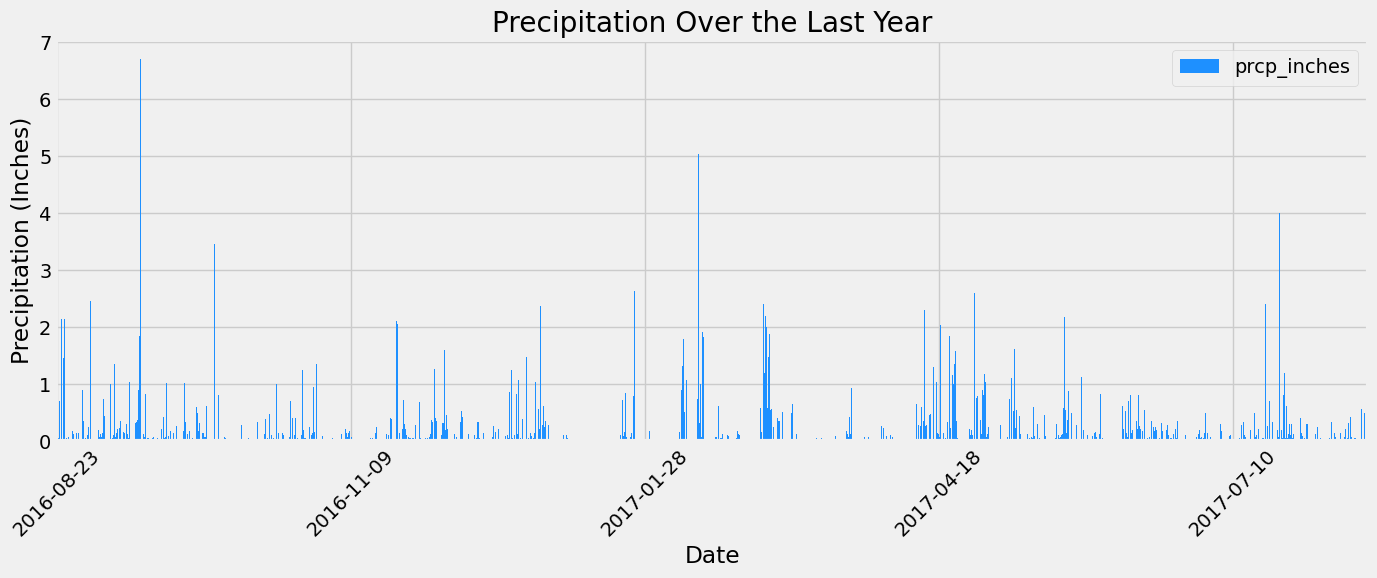

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
one_year_before = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
one_year_data = session.query(*sel).\
    filter(Measurement.date >= one_year_before).\
    all () 
    

# Save the query results as a Pandas DataFrame. Explicitly set the column names
one_year_data = pd.DataFrame(one_year_data, columns=['date', 'prcp_inches'])

# Sort the dataframe by date
sorted_one_year_data = one_year_data.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
ax = sorted_one_year_data.plot.bar(x='date', y='prcp_inches', figsize=(14, 6), color='dodgerblue', width=1)

ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (Inches)")
ax.set_title("Precipitation Over the Last Year")

ax.set_xticks(ax.get_xticks()[::500]) 
plt.xticks(rotation=45)

ax.yaxis.grid(True)

plt.tight_layout()  
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_statistics = one_year_data["prcp_inches"].describe()
print(prcp_statistics)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp_inches, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_count = session.query(func.count(Measurement.station.distinct())).scalar()
print(total_count)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
    Measurement.station,
    func.count(Measurement.station).label('count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for station, count in active_stations:
    print(f"{station}, {count}")

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

USC00519281_Data = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == "USC00519281").all()

USC00519281_Data

[(54.0, 85.0, 71.66378066378067)]

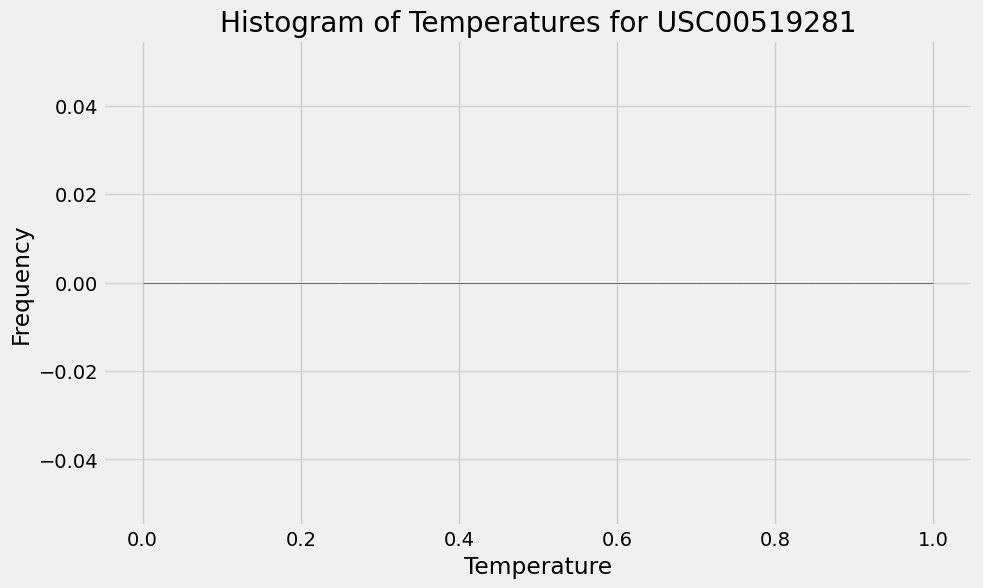

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_before = dt.date(2017, 8, 23) - dt.timedelta(days=365)

sel = [Measurement.date, Measurement.tobs]
one_year_temp_data = session.query(*sel).\
    filter(Measurement.station == 'USC00519281',
           Measurement.date >= one_year_before).\
    all () 
    
# Save the query results as a Pandas DataFrame. Explicitly set the column names
one_year_temp_data = pd.DataFrame(one_year_data, columns=['date', 'temp'])
one_year_temp_data.dropna(subset=['temp'], inplace=True)


plt.figure(figsize=(10, 6)) 
plt.hist(one_year_temp_data['temp'], bins=20, color='blue', alpha=0.7, edgecolor='black')  
plt.title('Histogram of Temperatures for USC00519281')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()  


# Close Session

In [16]:
# Close Session
session.close()
